In [1]:
import math
import random
import numpy

import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

tensor(0.0117) tensor(1.0030)
tensor(0.0307) tensor(5.4100)


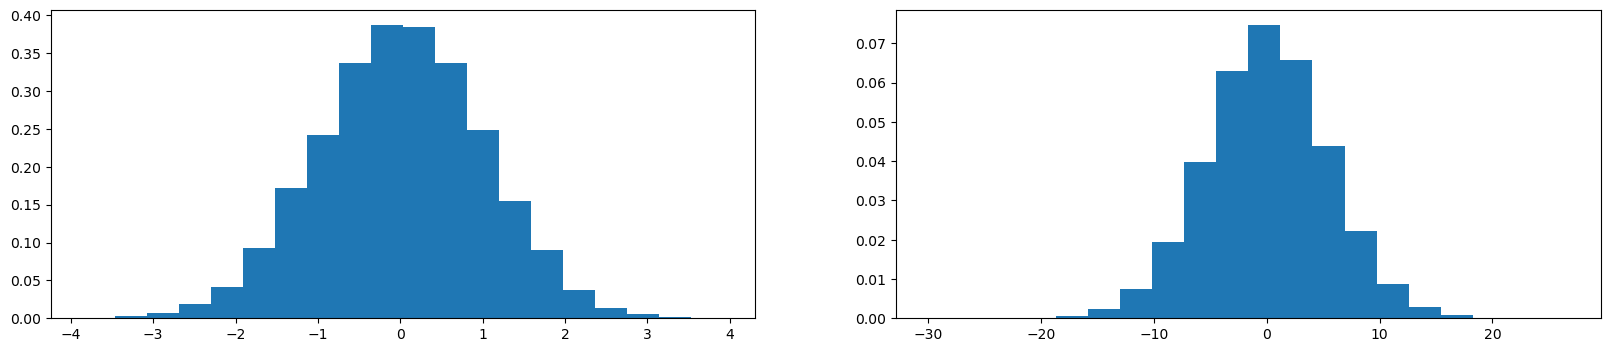

In [11]:
x = torch.randn(1000, 30) # 1000 inputs with 30 dims
w = torch.randn(30, 200) # 30 inputs, 200 neurons

y = x @ w 

# 
print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20, 4))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 20, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 20, density=True);

the stddev of x is 1.0030 but when x is acted upon by the w, it loses its sttdv and becomes much higher, 5.4100!!!

How can we scale the w's to preserve the distribution? What should we mulitply it by?

According to [Kaiming He et al.](https://openaccess.thecvf.com/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf) and [PyTorch Documentaion](https://pytorch.org/docs/stable/nn.init.html), 

we should scale the w's by gain/(fan_mode)**(0.5)

For the above example, we wil use fan_mode as fan_in, and lets say we are usinng tanh activation function

tensor(-0.0016) tensor(0.9997)
tensor(-0.0020) tensor(1.6591)


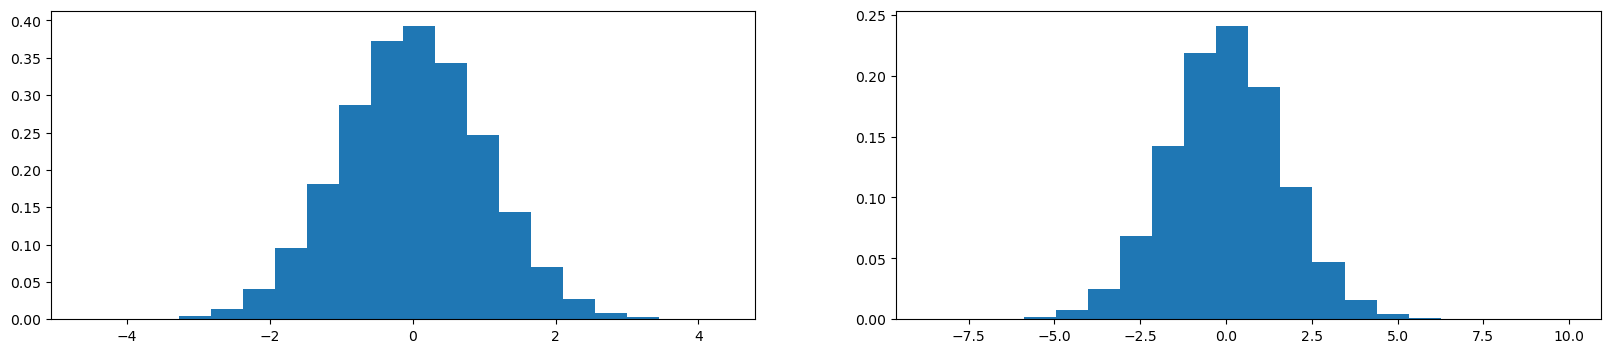

In [21]:
# correct way to initialise the network

tanh_gain = (5/3)
fan_in_w = 30
scaling_factor = (tanh_gain/ ((fan_in_w) ** 0.5))

x = torch.randn(10000, 30) 
w = torch.randn(30, 200) * scaling_factor

y = x @ w 

# 
print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20, 4))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 20, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 20, density=True);

Much better!!

What if we didnt? Lets try it out for our MLP network

In [23]:
words = open('names.txt', 'r').read().splitlines()
print(f'{len(words)}')
print(max(len(w) for w in words))
words[:8]

chars = list('abcdefghijklmnopqrstuvwxyz')
stoi_lookup = {c: i+1 for i, c in enumerate(chars)}
stoi_lookup['.'] = 0
itos_lookups = {i: char for char, i in stoi_lookup.items()}
vocab_size = len(itos_lookups)
print(itos_lookups)
print(vocab_size)

block_size = 3 # context length

def build_dataset(words):
    # input and output
    X, Y = [], []
    for word in words:
        # print('word: ', word)
        context = [0] * block_size
        seq = word + '.'    # don't forget to add the . add the end

        for char in seq:
            X.append(context)
            # index of the character to be predicted
            y_idx = stoi_lookup[char]
            Y.append(y_idx)
            # print(''.join(itos_lookups[c] for c in context), '--->', itos_lookups[y_i])
            # update the context for the next sequence
            context = context[1:] + [y_idx]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print("shapes: ", X.shape, Y.shape)
    return X, Y


random.seed(42)
random.shuffle(words)

train_window_end = int(0.8*len(words))
val_window_end = int(0.9*len(words))

X_train, Y_train = build_dataset(words[:train_window_end])  # used for optimizing the params of the model
X_val, Y_val = build_dataset(words[train_window_end:val_window_end])    #used for training the hyperparameters(hidden layer size, embedding size etc)
X_test, Y_test = build_dataset(words[val_window_end:])  # evaluating the performance of the model

32033
15
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27
shapes:  torch.Size([182625, 3]) torch.Size([182625])
shapes:  torch.Size([22655, 3]) torch.Size([22655])
shapes:  torch.Size([22866, 3]) torch.Size([22866])


In [32]:
dim_embd = 10 # dimensionality of the character embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, dim_embd),             generator=g)

W1 = torch.randn((dim_embd* block_size, n_hidden),  generator=g)
b1 = torch.randn(n_hidden,                          generator=g)

W2 = torch.randn((n_hidden, vocab_size),            generator=g)
b2 = torch.randn(vocab_size,                        generator=g)

params = [C, W1, W2, b2]
print(sum(p.nelement() for p in params))

# set the p.grad requires to true first so that we are able to get the grad for the params
for p in params:
    p.requires_grad = True

11697


In [33]:
max_steps = 200000
batch_size = 32
losses_at_idx = []

for step in range(max_steps):
    ix = torch.randint(0, X_train.shape[0], (batch_size, ), generator=g)
    Xb, Yb = X_train[ix], Y_train[ix]
    emb = C[Xb] 
    emb_cat = emb.view(emb.shape[0], -1) 
    h_preact = emb_cat @ W1
    h = torch.tanh(h_preact)
    logits = h @ W2 + b2
    
    loss = F.cross_entropy(logits, Yb)
    for p in params:
        p.grad = None
    loss.backward()

    l_rate = 0.1 if step < 100000 else 0.01

    for p in params:
        p.data += -l_rate * p.grad

    if step % 10000 == 0:
        print(f'{step:7d}/{max_steps:7d}:{loss.item():.4f}')
    
    losses_at_idx.append(loss.log10().item())

      0/ 200000:28.4938
  10000/ 200000:2.7107
  20000/ 200000:2.7328
  30000/ 200000:2.8817
  40000/ 200000:2.2179
  50000/ 200000:2.7231
  60000/ 200000:2.3383
  70000/ 200000:1.9438
  80000/ 200000:2.3174
  90000/ 200000:2.2901
 100000/ 200000:1.9561
 110000/ 200000:2.3601
 120000/ 200000:1.9801
 130000/ 200000:2.5132
 140000/ 200000:2.4024
 150000/ 200000:2.1228
 160000/ 200000:2.0676
 170000/ 200000:1.7587
 180000/ 200000:2.0534
 190000/ 200000:1.8617


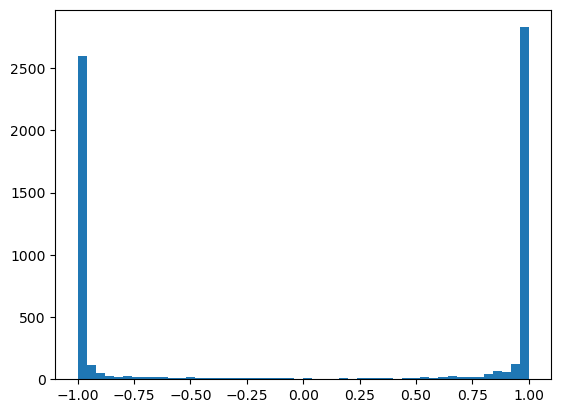

In [34]:
plt.hist(h.view(-1).tolist(), bins=50);

Issue 1: Loss is very high for the first few steps

Issue 2: From the above histogram, we can see that the output of the activation function is saturated towards the ends, -1 and 1.

Why is this an issue?

- The graph of tanh becomes flat at -1 and 1 implying that when an input is passed through it, there would be very no impact on the output of the tanh, therefore there would be no impact on the loss. 

    - The weights and biases along with this tanh neuron do not impact the loss much, the gradient will vanish. 

How can we remedy that? use Kaiming init method for initialization!

In [36]:
words = open('names.txt', 'r').read().splitlines()
print(f'{len(words)}')
print(max(len(w) for w in words))
words[:8]

chars = list('abcdefghijklmnopqrstuvwxyz')
stoi_lookup = {c: i+1 for i, c in enumerate(chars)}
stoi_lookup['.'] = 0
itos_lookups = {i: char for char, i in stoi_lookup.items()}
vocab_size = len(itos_lookups)
print(itos_lookups)
print(vocab_size)

block_size = 3 # context length

def build_dataset(words):
    # input and output
    X, Y = [], []
    for word in words:
        # print('word: ', word)
        context = [0] * block_size
        seq = word + '.'    # don't forget to add the . add the end

        for char in seq:
            X.append(context)
            # index of the character to be predicted
            y_idx = stoi_lookup[char]
            Y.append(y_idx)
            # print(''.join(itos_lookups[c] for c in context), '--->', itos_lookups[y_i])
            # update the context for the next sequence
            context = context[1:] + [y_idx]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print("shapes: ", X.shape, Y.shape)
    return X, Y


random.seed(42)
random.shuffle(words)

train_window_end = int(0.8*len(words))
val_window_end = int(0.9*len(words))

X_train, Y_train = build_dataset(words[:train_window_end])  # used for optimizing the params of the model
X_val, Y_val = build_dataset(words[train_window_end:val_window_end])    #used for training the hyperparameters(hidden layer size, embedding size etc)
X_test, Y_test = build_dataset(words[val_window_end:])  # evaluating the performance of the model

dim_embd = 10 # dimensionality of the character embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, dim_embd),             generator=g)

W1 = torch.randn((dim_embd* block_size, n_hidden),  generator=g) * (5/3)/(dim_embd* block_size) ** 0.5
b1 = torch.randn(n_hidden,                          generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.01 
b2 = torch.randn(vocab_size,                        generator=g) * 0.01

params = [C, W1, W2, b2]
print(sum(p.nelement() for p in params))

# set the p.grad requires to true first so that we are able to get the grad for the params
for p in params:
    p.requires_grad = True

32033
15
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27
shapes:  torch.Size([182625, 3]) torch.Size([182625])
shapes:  torch.Size([22655, 3]) torch.Size([22655])
shapes:  torch.Size([22866, 3]) torch.Size([22866])
11697


In [37]:
max_steps = 200000
batch_size = 32
losses_at_idx = []

for step in range(max_steps):
    ix = torch.randint(0, X_train.shape[0], (batch_size, ), generator=g)
    Xb, Yb = X_train[ix], Y_train[ix]

    emb = C[Xb]
    emb_cat = emb.view(emb.shape[0], -1)
    h_preact = emb_cat @ W1
    h = torch.tanh(h_preact)
    logits = h @ W2 + b2
    
    loss = F.cross_entropy(logits, Yb) 
    for p in params:
        p.grad = None

    loss.backward()

    l_rate = 0.1 if step < 100000 else 0.01

    for p in params:
        p.data += -l_rate * p.grad

    if step % 10000 == 0:
        print(f'{step:7d}/{max_steps:7d}:{loss.item():.4f}')
    
    losses_at_idx.append(loss.log10().item())

      0/ 200000:3.3174
  10000/ 200000:2.1933
  20000/ 200000:2.3245
  30000/ 200000:2.5370
  40000/ 200000:1.9727
  50000/ 200000:2.3194
  60000/ 200000:2.3861
  70000/ 200000:2.1519
  80000/ 200000:2.3071
  90000/ 200000:2.2269
 100000/ 200000:1.8243
 110000/ 200000:2.1290
 120000/ 200000:1.9451
 130000/ 200000:2.3685
 140000/ 200000:2.1037
 150000/ 200000:2.1439
 160000/ 200000:1.7670
 170000/ 200000:1.7760
 180000/ 200000:1.9447
 190000/ 200000:1.8037


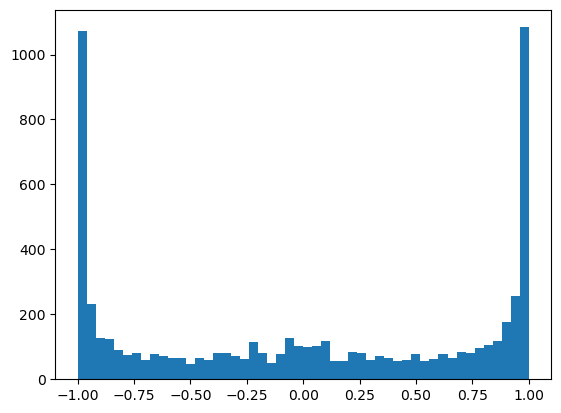

In [38]:
plt.hist(h.view(-1).tolist(), bins=50);